In [1]:
!pip install wrds
import pandas as pd
import wrds
conn = wrds.Connection(wrds_username='kaiyuw')
import numpy as np
from scipy.stats.mstats import winsorize
from scipy import stats

Enter your WRDS username [root]:kaiyuw
Enter your password:··········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [0]:
# 3.1 Sample selection
funda = conn.raw_sql("""
                      select distinct gvkey, datadate, fyear,fyr, oiadp, at, act,che, lct, dlc, txp, dp, exchg, sich
                      from compa.funda where
                      (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and
                      fyear<1992 and fyear>1962 and (exchg=11 or exchg=12)""")
company = conn.raw_sql("""
                        select gvkey, sic
                        from compa.company
                        """)
fundaclean=pd.merge(funda,company,on=['gvkey'])
fundaclean['sic1']=np.where(fundaclean['sich']>0,fundaclean['sich'],fundaclean['sic'])
fundaclean=fundaclean.drop(['sich','sic'],axis=1)
fundaclean['sic1']=fundaclean['sic1'].astype(int)

fundaclean = fundaclean[(fundaclean['exchg']==11)|(fundaclean['exchg']==12)]
fundaclean =fundaclean.drop_duplicates(['gvkey','fyear'],keep='last') 
act = fundaclean.copy()
# import datetime
# fundaclean['fyr']=pd.DatetimeIndex(fundaclean['datadate']).month

In [3]:
act

,gvkey,datadate,fyear,fyr,oiadp,at,act,che,lct,dlc,txp,dp,exchg,sic1
0,009392,1977-12-31,1977.0,12.0,87.384,1414.954,172.576,1.917,225.039,125.184,8.226,32.876,11.0,4931
1,009392,1988-12-31,1988.0,12.0,390.624,3532.691,319.946,38.086,510.110,141.006,7.979,168.684,11.0,4931
2,009392,1978-12-31,1978.0,12.0,104.719,1540.813,180.775,4.268,216.971,97.932,12.311,35.906,11.0,4931
3,009392,1975-12-31,1975.0,12.0,47.820,1010.172,106.625,2.615,139.632,81.185,3.763,28.876,11.0,4931
4,009392,1976-12-31,1976.0,12.0,82.843,1186.879,134.012,1.750,181.987,102.740,5.595,30.267,11.0,4931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65236,024818,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726
65237,022834,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726
65238,022834,1990-10-31,1990.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726
65239,024784,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726


In [0]:
data = ''
# act=act.drop_duplicates(subset=['gvkey','fyear'])
temp=act.copy()
at_lag= act[['gvkey','fyear','at']].copy() # you can use shift, but shift gives wrong lag variables when there are missing years. 
at_lag['fyear']=at_lag['fyear']+1
at_lag=at_lag.rename(columns={'at':'at_lag1'})

data=pd.merge(temp, at_lag, how='left', on=['gvkey','fyear'])

In [5]:
data

,gvkey,datadate,fyear,fyr,oiadp,at,act,che,lct,dlc,txp,dp,exchg,sic1,at_lag1
0,009392,1977-12-31,1977.0,12.0,87.384,1414.954,172.576,1.917,225.039,125.184,8.226,32.876,11.0,4931,1186.879
1,009392,1988-12-31,1988.0,12.0,390.624,3532.691,319.946,38.086,510.110,141.006,7.979,168.684,11.0,4931,3601.240
2,009392,1978-12-31,1978.0,12.0,104.719,1540.813,180.775,4.268,216.971,97.932,12.311,35.906,11.0,4931,1414.954
3,009392,1975-12-31,1975.0,12.0,47.820,1010.172,106.625,2.615,139.632,81.185,3.763,28.876,11.0,4931,891.447
4,009392,1976-12-31,1976.0,12.0,82.843,1186.879,134.012,1.750,181.987,102.740,5.595,30.267,11.0,4931,1010.172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65234,024818,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN
65235,022834,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN
65236,022834,1990-10-31,1990.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN
65237,024784,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN


In [0]:
actrual_lag= act[['gvkey','fyear','act','che','lct','dlc','txp','dp']].copy() # you can use shift, but shift gives wrong lag variables when there are missing years. 
actrual_lag['fyear']=actrual_lag['fyear']+1
actrual_lag=actrual_lag.rename(columns={'act':'act_lag1','che':'che_lag1','lct':'lct_lag1','dlc':'dlc_lag1','txp':'txp_lag1','dp':'dp_lag1',})

data=pd.merge(data, actrual_lag, how='left', on=['gvkey','fyear'])

In [7]:
data

,gvkey,datadate,fyear,fyr,oiadp,at,act,che,lct,dlc,txp,dp,exchg,sic1,at_lag1,act_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,dp_lag1
0,009392,1977-12-31,1977.0,12.0,87.384,1414.954,172.576,1.917,225.039,125.184,8.226,32.876,11.0,4931,1186.879,134.012,1.750,181.987,102.740,5.595,30.267
1,009392,1988-12-31,1988.0,12.0,390.624,3532.691,319.946,38.086,510.110,141.006,7.979,168.684,11.0,4931,3601.240,336.411,84.178,533.691,150.445,NaN,142.557
2,009392,1978-12-31,1978.0,12.0,104.719,1540.813,180.775,4.268,216.971,97.932,12.311,35.906,11.0,4931,1414.954,172.576,1.917,225.039,125.184,8.226,32.876
3,009392,1975-12-31,1975.0,12.0,47.820,1010.172,106.625,2.615,139.632,81.185,3.763,28.876,11.0,4931,891.447,84.180,5.794,79.374,30.775,9.487,25.175
4,009392,1976-12-31,1976.0,12.0,82.843,1186.879,134.012,1.750,181.987,102.740,5.595,30.267,11.0,4931,1010.172,106.625,2.615,139.632,81.185,3.763,28.876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65234,024818,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65235,022834,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65236,022834,1990-10-31,1990.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65237,024784,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
data['Earnings'] = data['oiadp']/((data['at']+data['at_lag1'])/2)
data['ca']=data['act']-data['act_lag1']
data['cash']=data['che']-data['che_lag1']
data['cl']=data['lct']-data['lct_lag1']
data['std']=data['dlc']-data['dlc_lag1']
data['tp']=data['txp']-data['txp_lag1']

In [9]:
data

,gvkey,datadate,fyear,fyr,oiadp,at,act,che,lct,dlc,txp,dp,exchg,sic1,at_lag1,act_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,dp_lag1,Earnings,ca,cash,cl,std,tp
0,009392,1977-12-31,1977.0,12.0,87.384,1414.954,172.576,1.917,225.039,125.184,8.226,32.876,11.0,4931,1186.879,134.012,1.750,181.987,102.740,5.595,30.267,0.067171,38.564,0.167,43.052,22.444,2.631
1,009392,1988-12-31,1988.0,12.0,390.624,3532.691,319.946,38.086,510.110,141.006,7.979,168.684,11.0,4931,3601.240,336.411,84.178,533.691,150.445,NaN,142.557,0.109512,-16.465,-46.092,-23.581,-9.439,NaN
2,009392,1978-12-31,1978.0,12.0,104.719,1540.813,180.775,4.268,216.971,97.932,12.311,35.906,11.0,4931,1414.954,172.576,1.917,225.039,125.184,8.226,32.876,0.070857,8.199,2.351,-8.068,-27.252,4.085
3,009392,1975-12-31,1975.0,12.0,47.820,1010.172,106.625,2.615,139.632,81.185,3.763,28.876,11.0,4931,891.447,84.180,5.794,79.374,30.775,9.487,25.175,0.050294,22.445,-3.179,60.258,50.410,-5.724
4,009392,1976-12-31,1976.0,12.0,82.843,1186.879,134.012,1.750,181.987,102.740,5.595,30.267,11.0,4931,1010.172,106.625,2.615,139.632,81.185,3.763,28.876,0.075413,27.387,-0.865,42.355,21.555,1.832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65234,024818,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65235,022834,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65236,022834,1990-10-31,1990.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65237,024784,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
data['Accruals'] = ((data['ca']-data['cash'])-(data['cl']-data['std']-data['tp'])-data['dp'])/((data['at']+data['at_lag1'])/2)
data['CashFlow']=data['Earnings']-data['Accruals']
# data[['gvkey','fyear','datadate','Earnings','Accruals','CashFlow']]

In [0]:
data
act = data.copy()

In [0]:
# act.fyear.unique().astype(int).tolist()


In [12]:
act2=pd.DataFrame()
yearlist=act.fyear.unique().astype(int).tolist()
yearlist.sort()
for year in yearlist:
  acttmp=act[act['fyear']==year]
  acttmp['AccrualDecile'] = pd.qcut(act['Accruals'], 10, labels=[1,2,3,4,5,6,7,8,9,10])
  act2 = act2.append(acttmp)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
act2

,gvkey,datadate,fyear,fyr,oiadp,at,act,che,lct,dlc,txp,dp,exchg,sic1,at_lag1,act_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,dp_lag1,Earnings,ca,cash,cl,std,tp,Accruals,CashFlow,AccrualDecile
8,009392,1963-12-31,1963.0,12.0,28.964,308.185,15.904,NaN,32.034,7.875,NaN,10.538,11.0,4931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,009405,1963-12-31,1963.0,12.0,3.640,23.100,11.600,3.500,6.700,1.400,NaN,3.700,11.0,8711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,002408,1963-12-31,1963.0,12.0,27.878,327.966,18.094,0.629,23.723,6.500,5.615,15.649,11.0,4812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,010801,1963-12-31,1963.0,12.0,12.050,126.602,13.537,NaN,8.307,1.321,NaN,2.725,11.0,4932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,007938,1963-12-31,1963.0,12.0,2.110,31.600,11.057,6.300,3.200,0.800,NaN,2.120,11.0,1221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65233,062831,1991-12-31,1991.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,4813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65234,024818,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65235,022834,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65237,024784,1991-10-31,1991.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
fundaclean1 = act2[['gvkey','fyear','datadate','sic1','Earnings','Accruals','CashFlow','AccrualDecile']].copy()
fundaclean1 = fundaclean1.dropna()
temp = fundaclean1.copy()
fundaclean1

,gvkey,fyear,datadate,sic1,Earnings,Accruals,CashFlow,AccrualDecile
69,002408,1964.0,1964-12-31,4812,0.089976,-0.061553,0.151529,3
213,011155,1964.0,1964-12-31,3089,0.021433,-0.067314,0.088747,3
264,007163,1964.0,1964-12-31,7323,0.228090,0.021547,0.206543,8
353,011691,1964.0,1965-03-31,3430,0.162145,0.007022,0.155123,8
764,009225,1964.0,1965-04-30,7340,0.119317,-0.010267,0.129585,7
...,...,...,...,...,...,...,...,...
65141,020192,1991.0,1991-12-31,2834,-0.161326,0.038286,-0.199612,9
65156,025807,1991.0,1992-02-29,7370,0.150914,-0.164440,0.315354,1
65159,024522,1991.0,1992-02-29,5331,0.125653,-0.035971,0.161625,5
65188,015315,1991.0,1991-12-31,3841,0.014438,-0.078592,0.093030,2


In [0]:
crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1962' and '12/31/1994'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """) 

In [16]:
crsp_m

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc
0,10006.0,22156.0,1968-09-30,10.0,1.0,-0.058296,-0.058296,5643.0,52.500
1,10006.0,22156.0,1962-01-31,10.0,1.0,0.087523,0.087523,1427.0,73.000
2,10006.0,22156.0,1962-02-28,10.0,1.0,0.011986,0.003425,1427.0,73.250
3,10006.0,22156.0,1962-03-30,10.0,1.0,-0.071672,-0.071672,1427.0,68.000
4,10006.0,22156.0,1962-04-30,10.0,1.0,0.056985,0.056985,1427.0,71.875
...,...,...,...,...,...,...,...,...,...
854172,93236.0,7777.0,1991-12-31,11.0,2.0,0.024390,0.024390,3450.0,15.750
854173,93236.0,7777.0,1992-01-31,11.0,2.0,0.182540,0.182540,3450.0,18.625
854174,93236.0,7777.0,1992-02-28,11.0,2.0,-0.181208,-0.181208,3450.0,15.250
854175,93236.0,7777.0,1992-03-31,11.0,2.0,-0.122951,-0.122951,3450.0,13.375


In [49]:
crsp =''
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """)
dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
dlret['jdate']=dlret['dlstdt']+pd.offsets.MonthEnd(0)
crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
# crsp = crsp[['permno','date','ret','shrout','prc','retadj' ,'me','retadjsize']]
# crsp = crsp[['permno','date','ret','shrout','prc','retadj' ,'me']]
crsp

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,dlret,dlstdt,retadj,me
0,10006.0,22156.0,1968-09-30,10.0,1.0,-0.058296,-0.058296,5643.0,52.500,1968-09-30,0.0,NaT,-0.058296,296257.500
1,10006.0,22156.0,1962-01-31,10.0,1.0,0.087523,0.087523,1427.0,73.000,1962-01-31,0.0,NaT,0.087523,104171.000
2,10006.0,22156.0,1962-02-28,10.0,1.0,0.011986,0.003425,1427.0,73.250,1962-02-28,0.0,NaT,0.011986,104527.750
3,10006.0,22156.0,1962-03-30,10.0,1.0,-0.071672,-0.071672,1427.0,68.000,1962-03-31,0.0,NaT,-0.071672,97036.000
4,10006.0,22156.0,1962-04-30,10.0,1.0,0.056985,0.056985,1427.0,71.875,1962-04-30,0.0,NaT,0.056985,102565.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854172,93236.0,7777.0,1991-12-31,11.0,2.0,0.024390,0.024390,3450.0,15.750,1991-12-31,0.0,NaT,0.024390,54337.500
854173,93236.0,7777.0,1992-01-31,11.0,2.0,0.182540,0.182540,3450.0,18.625,1992-01-31,0.0,NaT,0.182540,64256.250
854174,93236.0,7777.0,1992-02-28,11.0,2.0,-0.181208,-0.181208,3450.0,15.250,1992-02-29,0.0,NaT,-0.181208,52612.500
854175,93236.0,7777.0,1992-03-31,11.0,2.0,-0.122951,-0.122951,3450.0,13.375,1992-03-31,0.0,NaT,-0.122951,46143.750


In [0]:
# ## Add delisting return, get delisting-adjusted return (retadj), calculate market value (me)
# dlret = conn.raw_sql("""
#                     select permno, dlret, dlstdt 
#                     from crsp.msedelist
#                     """)

# ## Line up date to be end of month
# dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
# dlret['jdate']=dlret['dlstdt']+pd.offsets.MonthEnd(0)
# crsp_m['date']=pd.to_datetime(crsp_m['date'])
# crsp_m['jdate']=crsp_m['date']+pd.offsets.MonthEnd(0)

# ## Adjust delisting return
# crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
# crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1

# ## Market value
# crsp['me']=crsp['prc'].abs()*crsp['shrout'] 

# # crsp=crsp.drop(['shrout', 'prc','dlret','dlstdt'], axis=1)
# crsp

In [51]:
ermport2 = conn.raw_sql("""
                      select *
                      from crsp.ermport2 as a
                      where a.date between '01/01/1962' and '12/31/1994'
                      """) 
ermport2
# crsp['retadjsize'] =crsp['retadj']-crsp['decret'] 

,permno,ret,date,capn,decret
0,10006.0,0.087523,1962-01-31,8.0,-0.024409
1,10006.0,0.011986,1962-02-28,8.0,0.020682
2,10006.0,-0.071672,1962-03-30,8.0,-0.007803
3,10006.0,0.056985,1962-04-30,8.0,-0.057194
4,10006.0,-0.160000,1962-05-31,8.0,-0.101274
...,...,...,...,...,...
965959,93236.0,0.428571,1994-08-31,2.0,0.027912
965960,93236.0,-0.266667,1994-09-30,2.0,0.010706
965961,93236.0,-0.015152,1994-10-31,2.0,-0.000148
965962,93236.0,-0.076923,1994-11-30,2.0,-0.028827


In [0]:
ermport2['date']=pd.to_datetime(ermport2['date'])
ermport2['jdate']=ermport2['date']+pd.offsets.MonthEnd(0)
ermport2=ermport2.drop(['date','ret','capn'],axis=1)

In [0]:
crsp = pd.merge(crsp, ermport2, how='left',on=['permno','jdate'])

In [54]:
crsp['retadjsize'] =crsp['retadj']-crsp['decret'] 
crsp

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,dlret,dlstdt,retadj,me,decret,retadjsize
0,10006.0,22156.0,1968-09-30,10.0,1.0,-0.058296,-0.058296,5643.0,52.500,1968-09-30,0.0,NaT,-0.058296,296257.500,0.058943,-0.117239
1,10006.0,22156.0,1962-01-31,10.0,1.0,0.087523,0.087523,1427.0,73.000,1962-01-31,0.0,NaT,0.087523,104171.000,-0.024409,0.111932
2,10006.0,22156.0,1962-02-28,10.0,1.0,0.011986,0.003425,1427.0,73.250,1962-02-28,0.0,NaT,0.011986,104527.750,0.020682,-0.008696
3,10006.0,22156.0,1962-03-30,10.0,1.0,-0.071672,-0.071672,1427.0,68.000,1962-03-31,0.0,NaT,-0.071672,97036.000,-0.007803,-0.063870
4,10006.0,22156.0,1962-04-30,10.0,1.0,0.056985,0.056985,1427.0,71.875,1962-04-30,0.0,NaT,0.056985,102565.625,-0.057194,0.114179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854172,93236.0,7777.0,1991-12-31,11.0,2.0,0.024390,0.024390,3450.0,15.750,1991-12-31,0.0,NaT,0.024390,54337.500,0.056200,-0.031809
854173,93236.0,7777.0,1992-01-31,11.0,2.0,0.182540,0.182540,3450.0,18.625,1992-01-31,0.0,NaT,0.182540,64256.250,0.122705,0.059835
854174,93236.0,7777.0,1992-02-28,11.0,2.0,-0.181208,-0.181208,3450.0,15.250,1992-02-29,0.0,NaT,-0.181208,52612.500,0.036810,-0.218018
854175,93236.0,7777.0,1992-03-31,11.0,2.0,-0.122951,-0.122951,3450.0,13.375,1992-03-31,0.0,NaT,-0.122951,46143.750,-0.020119,-0.102832


In [0]:
crsp = crsp[['permno','date','ret','shrout','prc','retadj' ,'me','retadjsize','jdate']]

In [0]:
crsp_temp = crsp.copy()
crsp = crsp.dropna()

In [57]:
crsp

,permno,date,ret,shrout,prc,retadj,me,retadjsize,jdate
0,10006.0,1968-09-30,-0.058296,5643.0,52.500,-0.058296,296257.500,-0.117239,1968-09-30
1,10006.0,1962-01-31,0.087523,1427.0,73.000,0.087523,104171.000,0.111932,1962-01-31
2,10006.0,1962-02-28,0.011986,1427.0,73.250,0.011986,104527.750,-0.008696,1962-02-28
3,10006.0,1962-03-30,-0.071672,1427.0,68.000,-0.071672,97036.000,-0.063870,1962-03-31
4,10006.0,1962-04-30,0.056985,1427.0,71.875,0.056985,102565.625,0.114179,1962-04-30
...,...,...,...,...,...,...,...,...,...
854172,93236.0,1991-12-31,0.024390,3450.0,15.750,0.024390,54337.500,-0.031809,1991-12-31
854173,93236.0,1992-01-31,0.182540,3450.0,18.625,0.182540,64256.250,0.059835,1992-01-31
854174,93236.0,1992-02-28,-0.181208,3450.0,15.250,-0.181208,52612.500,-0.218018,1992-02-29
854175,93236.0,1992-03-31,-0.122951,3450.0,13.375,-0.122951,46143.750,-0.102832,1992-03-31


In [58]:
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """)
ccm['linkdt']=pd.to_datetime(ccm['linkdt'])
ccm['linkenddt']=pd.to_datetime(ccm['linkenddt'])
# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))
ccm

,gvkey,permno,linktype,linkprim,linkdt,linkenddt
0,001000,25881.0,LU,P,1970-11-13,1978-06-30 00:00:00.000000
1,001001,10015.0,LU,P,1983-09-20,1986-07-31 00:00:00.000000
2,001002,10023.0,LC,C,1972-12-14,1973-06-05 00:00:00.000000
3,001003,10031.0,LU,C,1983-12-07,1989-08-16 00:00:00.000000
4,001004,54594.0,LU,P,1972-04-24,2020-02-29 21:44:59.831668
...,...,...,...,...,...,...
33380,328795,18144.0,LC,P,2018-11-01,2020-02-29 21:44:59.831668
33381,330227,18399.0,LC,P,2019-02-11,2020-02-29 21:44:59.831668
33382,330942,18444.0,LS,P,2019-03-13,2020-02-29 21:44:59.831668
33383,331856,14615.0,LC,P,2019-04-15,2020-02-29 21:44:59.831668


In [59]:
# Merge fundclean1 with ccm and get ccm1
ccm1=pd.merge(fundaclean1[['gvkey','datadate','fyear','AccrualDecile']],ccm,how='left',on=['gvkey'])
ccm1['jdate0']=ccm1['datadate']+pd.offsets.MonthEnd(5)
ccm1

,gvkey,datadate,fyear,AccrualDecile,permno,linktype,linkprim,linkdt,linkenddt,jdate0
0,002408,1964-12-31,1964.0,3,13786.0,LC,P,2013-02-04,2020-02-29 21:44:59.831668,1965-05-31
1,002408,1964-12-31,1964.0,3,88658.0,LC,P,2000-10-17,2013-01-31 00:00:00.000000,1965-05-31
2,011155,1964-12-31,1964.0,3,37815.0,LC,C,1963-01-01,1968-01-30 00:00:00.000000,1965-05-31
3,011155,1964-12-31,1964.0,3,37815.0,LC,P,1968-01-31,1998-05-29 00:00:00.000000,1965-05-31
4,007163,1964-12-31,1964.0,8,17478.0,LU,C,1950-01-01,1962-01-30 00:00:00.000000,1965-05-31
...,...,...,...,...,...,...,...,...,...,...
58350,020192,1991-12-31,1991.0,9,75929.0,LU,P,1990-01-23,1999-12-31 00:00:00.000000,1992-05-31
58351,025807,1992-02-29,1991.0,1,77803.0,LC,P,1992-07-22,2006-08-31 00:00:00.000000,1992-07-31
58352,024522,1992-02-29,1991.0,5,77077.0,LU,P,1991-10-08,2005-12-30 00:00:00.000000,1992-07-31
58353,015315,1991-12-31,1991.0,2,75477.0,LU,P,1989-04-14,2004-06-30 00:00:00.000000,1992-05-31


In [0]:
# jdate between linkdt and linkenddt
ccm2=ccm1[(ccm1['jdate0']>=ccm1['linkdt'])&(ccm1['jdate0']<=ccm1['linkenddt'])]

In [61]:
ccm2

,gvkey,datadate,fyear,AccrualDecile,permno,linktype,linkprim,linkdt,linkenddt,jdate0
2,011155,1964-12-31,1964.0,3,37815.0,LC,C,1963-01-01,1968-01-30 00:00:00.000000,1965-05-31
5,007163,1964-12-31,1964.0,8,17478.0,LU,P,1962-01-31,2020-02-29 21:44:59.831668,1965-05-31
7,009225,1965-04-30,1964.0,7,36003.0,LU,P,1962-07-02,2020-02-29 21:44:59.831668,1965-09-30
10,009967,1964-12-31,1964.0,8,10735.0,LU,P,1962-01-31,1968-01-12 00:00:00.000000,1965-05-31
20,006260,1965-01-31,1964.0,3,12626.0,LU,P,1962-01-31,1984-11-30 00:00:00.000000,1965-06-30
...,...,...,...,...,...,...,...,...,...,...
58350,020192,1991-12-31,1991.0,9,75929.0,LU,P,1990-01-23,1999-12-31 00:00:00.000000,1992-05-31
58351,025807,1992-02-29,1991.0,1,77803.0,LC,P,1992-07-22,2006-08-31 00:00:00.000000,1992-07-31
58352,024522,1992-02-29,1991.0,5,77077.0,LU,P,1991-10-08,2005-12-30 00:00:00.000000,1992-07-31
58353,015315,1991-12-31,1991.0,2,75477.0,LU,P,1989-04-14,2004-06-30 00:00:00.000000,1992-05-31


In [62]:

# Portfolio ending date: holding 12 months after starting date
ccm2['jdate1']=ccm2['jdate0']+pd.offsets.MonthEnd(11)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [63]:
ccm2

,gvkey,datadate,fyear,AccrualDecile,permno,linktype,linkprim,linkdt,linkenddt,jdate0,jdate1
2,011155,1964-12-31,1964.0,3,37815.0,LC,C,1963-01-01,1968-01-30 00:00:00.000000,1965-05-31,1966-04-30
5,007163,1964-12-31,1964.0,8,17478.0,LU,P,1962-01-31,2020-02-29 21:44:59.831668,1965-05-31,1966-04-30
7,009225,1965-04-30,1964.0,7,36003.0,LU,P,1962-07-02,2020-02-29 21:44:59.831668,1965-09-30,1966-08-31
10,009967,1964-12-31,1964.0,8,10735.0,LU,P,1962-01-31,1968-01-12 00:00:00.000000,1965-05-31,1966-04-30
20,006260,1965-01-31,1964.0,3,12626.0,LU,P,1962-01-31,1984-11-30 00:00:00.000000,1965-06-30,1966-05-31
...,...,...,...,...,...,...,...,...,...,...,...
58350,020192,1991-12-31,1991.0,9,75929.0,LU,P,1990-01-23,1999-12-31 00:00:00.000000,1992-05-31,1993-04-30
58351,025807,1992-02-29,1991.0,1,77803.0,LC,P,1992-07-22,2006-08-31 00:00:00.000000,1992-07-31,1993-06-30
58352,024522,1992-02-29,1991.0,5,77077.0,LU,P,1991-10-08,2005-12-30 00:00:00.000000,1992-07-31,1993-06-30
58353,015315,1991-12-31,1991.0,2,75477.0,LU,P,1989-04-14,2004-06-30 00:00:00.000000,1992-05-31,1993-04-30


In [64]:
crsp

,permno,date,ret,shrout,prc,retadj,me,retadjsize,jdate
0,10006.0,1968-09-30,-0.058296,5643.0,52.500,-0.058296,296257.500,-0.117239,1968-09-30
1,10006.0,1962-01-31,0.087523,1427.0,73.000,0.087523,104171.000,0.111932,1962-01-31
2,10006.0,1962-02-28,0.011986,1427.0,73.250,0.011986,104527.750,-0.008696,1962-02-28
3,10006.0,1962-03-30,-0.071672,1427.0,68.000,-0.071672,97036.000,-0.063870,1962-03-31
4,10006.0,1962-04-30,0.056985,1427.0,71.875,0.056985,102565.625,0.114179,1962-04-30
...,...,...,...,...,...,...,...,...,...
854172,93236.0,1991-12-31,0.024390,3450.0,15.750,0.024390,54337.500,-0.031809,1991-12-31
854173,93236.0,1992-01-31,0.182540,3450.0,18.625,0.182540,64256.250,0.059835,1992-01-31
854174,93236.0,1992-02-28,-0.181208,3450.0,15.250,-0.181208,52612.500,-0.218018,1992-02-29
854175,93236.0,1992-03-31,-0.122951,3450.0,13.375,-0.122951,46143.750,-0.102832,1992-03-31


In [65]:
# Merge ccm2 with CRSP
crspcomp=pd.merge(crsp,ccm2,how='left',on=['permno'])
# crspcomp['jdate']=pd.to_datetime(crspcomp['jdate'])
crspcomp=crspcomp[(crspcomp['jdate']>=crspcomp['jdate0']) & (crspcomp['jdate']<=crspcomp['jdate1'])]
# crspcomp=crspcomp[['gvkey','permno','datadate','fyear','AccrualDecile','jdate0','jdate1']]

crspcomp_temp= crspcomp.copy()
crspcomp


,permno,date,ret,shrout,prc,retadj,me,retadjsize,jdate,gvkey,datadate,fyear,AccrualDecile,linktype,linkprim,linkdt,linkenddt,jdate0,jdate1
667,10014.0,1974-09-30,0.000000,5460.0,1.375,0.000000,7507.500,0.072795,1974-09-30,001031,1974-03-31,1973.0,9,LU,P,1966-01-31,1977-03-31,1974-08-31,1975-07-31
673,10014.0,1974-10-31,0.090909,5460.0,1.500,0.090909,8190.000,0.010800,1974-10-31,001031,1974-03-31,1973.0,9,LU,P,1966-01-31,1977-03-31,1974-08-31,1975-07-31
679,10014.0,1974-11-29,-0.250000,5077.0,1.125,-0.250000,5711.625,-0.186971,1974-11-30,001031,1974-03-31,1973.0,9,LU,P,1966-01-31,1977-03-31,1974-08-31,1975-07-31
685,10014.0,1974-12-31,0.000000,5077.0,1.125,0.000000,5711.625,0.078904,1974-12-31,001031,1974-03-31,1973.0,9,LU,P,1966-01-31,1977-03-31,1974-08-31,1975-07-31
691,10014.0,1975-01-31,0.333333,5077.0,1.500,0.333333,7615.500,-0.064549,1975-01-31,001031,1974-03-31,1973.0,9,LU,P,1966-01-31,1977-03-31,1974-08-31,1975-07-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9032813,93201.0,1989-09-29,0.035088,14790.0,7.375,0.035088,109076.250,0.026331,1989-09-30,011620,1989-03-31,1988.0,4,LU,P,1984-10-04,1990-02-28,1989-08-31,1990-07-31
9032818,93201.0,1989-10-31,0.050847,14790.0,7.750,0.050847,114622.500,0.094719,1989-10-31,011620,1989-03-31,1988.0,4,LU,P,1984-10-04,1990-02-28,1989-08-31,1990-07-31
9032823,93201.0,1989-11-30,0.209677,14790.0,9.375,0.209677,138656.250,0.197636,1989-11-30,011620,1989-03-31,1988.0,4,LU,P,1984-10-04,1990-02-28,1989-08-31,1990-07-31
9032828,93201.0,1989-12-29,0.040000,14843.0,9.750,0.040000,144719.250,0.040443,1989-12-31,011620,1989-03-31,1988.0,4,LU,P,1984-10-04,1990-02-28,1989-08-31,1990-07-31


In [0]:
crspcomp['1+retadj']=crspcomp['retadj']+1
crspcomp['1+retadjsize']=crspcomp['retadjsize']+1
# Group by gvkey, fyear: 
crspcomp['cumretrawyr1']=crspcomp.groupby(['gvkey','datadate'])['1+retadj'].cumprod()-1 
crspcomp['cumretsizeadjyr1']=crspcomp.groupby(['gvkey','datadate'])['1+retadjsize'].cumprod()-1 


In [67]:
crspcomp

,permno,date,ret,shrout,prc,retadj,me,retadjsize,jdate,gvkey,datadate,fyear,AccrualDecile,linktype,linkprim,linkdt,linkenddt,jdate0,jdate1,1+retadj,1+retadjsize,cumretrawyr1,cumretsizeadjyr1
667,10014.0,1974-09-30,0.000000,5460.0,1.375,0.000000,7507.500,0.072795,1974-09-30,001031,1974-03-31,1973.0,9,LU,P,1966-01-31,1977-03-31,1974-08-31,1975-07-31,1.000000,1.072795,0.000000,0.072795
673,10014.0,1974-10-31,0.090909,5460.0,1.500,0.090909,8190.000,0.010800,1974-10-31,001031,1974-03-31,1973.0,9,LU,P,1966-01-31,1977-03-31,1974-08-31,1975-07-31,1.090909,1.010800,0.090909,0.084381
679,10014.0,1974-11-29,-0.250000,5077.0,1.125,-0.250000,5711.625,-0.186971,1974-11-30,001031,1974-03-31,1973.0,9,LU,P,1966-01-31,1977-03-31,1974-08-31,1975-07-31,0.750000,0.813029,-0.181818,-0.118367
685,10014.0,1974-12-31,0.000000,5077.0,1.125,0.000000,5711.625,0.078904,1974-12-31,001031,1974-03-31,1973.0,9,LU,P,1966-01-31,1977-03-31,1974-08-31,1975-07-31,1.000000,1.078904,-0.181818,-0.048803
691,10014.0,1975-01-31,0.333333,5077.0,1.500,0.333333,7615.500,-0.064549,1975-01-31,001031,1974-03-31,1973.0,9,LU,P,1966-01-31,1977-03-31,1974-08-31,1975-07-31,1.333333,0.935451,0.090909,-0.110201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9032813,93201.0,1989-09-29,0.035088,14790.0,7.375,0.035088,109076.250,0.026331,1989-09-30,011620,1989-03-31,1988.0,4,LU,P,1984-10-04,1990-02-28,1989-08-31,1990-07-31,1.035088,1.026331,0.229167,0.191771
9032818,93201.0,1989-10-31,0.050847,14790.0,7.750,0.050847,114622.500,0.094719,1989-10-31,011620,1989-03-31,1988.0,4,LU,P,1984-10-04,1990-02-28,1989-08-31,1990-07-31,1.050847,1.094719,0.291667,0.304654
9032823,93201.0,1989-11-30,0.209677,14790.0,9.375,0.209677,138656.250,0.197636,1989-11-30,011620,1989-03-31,1988.0,4,LU,P,1984-10-04,1990-02-28,1989-08-31,1990-07-31,1.209677,1.197636,0.562500,0.562500
9032828,93201.0,1989-12-29,0.040000,14843.0,9.750,0.040000,144719.250,0.040443,1989-12-31,011620,1989-03-31,1988.0,4,LU,P,1984-10-04,1990-02-28,1989-08-31,1990-07-31,1.040000,1.040443,0.625000,0.625693


In [0]:
data = crspcomp[['gvkey','datadate','fyear','AccrualDecile','permno','jdate0','jdate1','cumretrawyr1','cumretsizeadjyr1']]

In [69]:
data

,gvkey,datadate,fyear,AccrualDecile,permno,jdate0,jdate1,cumretrawyr1,cumretsizeadjyr1
667,001031,1974-03-31,1973.0,9,10014.0,1974-08-31,1975-07-31,0.000000,0.072795
673,001031,1974-03-31,1973.0,9,10014.0,1974-08-31,1975-07-31,0.090909,0.084381
679,001031,1974-03-31,1973.0,9,10014.0,1974-08-31,1975-07-31,-0.181818,-0.118367
685,001031,1974-03-31,1973.0,9,10014.0,1974-08-31,1975-07-31,-0.181818,-0.048803
691,001031,1974-03-31,1973.0,9,10014.0,1974-08-31,1975-07-31,0.090909,-0.110201
...,...,...,...,...,...,...,...,...,...
9032813,011620,1989-03-31,1988.0,4,93201.0,1989-08-31,1990-07-31,0.229167,0.191771
9032818,011620,1989-03-31,1988.0,4,93201.0,1989-08-31,1990-07-31,0.291667,0.304654
9032823,011620,1989-03-31,1988.0,4,93201.0,1989-08-31,1990-07-31,0.562500,0.562500
9032828,011620,1989-03-31,1988.0,4,93201.0,1989-08-31,1990-07-31,0.625000,0.625693


In [0]:
data_temp = data.copy()

In [71]:
data.dropna()

,gvkey,datadate,fyear,AccrualDecile,permno,jdate0,jdate1,cumretrawyr1,cumretsizeadjyr1
667,001031,1974-03-31,1973.0,9,10014.0,1974-08-31,1975-07-31,0.000000,0.072795
673,001031,1974-03-31,1973.0,9,10014.0,1974-08-31,1975-07-31,0.090909,0.084381
679,001031,1974-03-31,1973.0,9,10014.0,1974-08-31,1975-07-31,-0.181818,-0.118367
685,001031,1974-03-31,1973.0,9,10014.0,1974-08-31,1975-07-31,-0.181818,-0.048803
691,001031,1974-03-31,1973.0,9,10014.0,1974-08-31,1975-07-31,0.090909,-0.110201
...,...,...,...,...,...,...,...,...,...
9032813,011620,1989-03-31,1988.0,4,93201.0,1989-08-31,1990-07-31,0.229167,0.191771
9032818,011620,1989-03-31,1988.0,4,93201.0,1989-08-31,1990-07-31,0.291667,0.304654
9032823,011620,1989-03-31,1988.0,4,93201.0,1989-08-31,1990-07-31,0.562500,0.562500
9032828,011620,1989-03-31,1988.0,4,93201.0,1989-08-31,1990-07-31,0.625000,0.625693


In [104]:
cumretrawyr1=data.groupby('AccrualDecile')['cumretrawyr1'].mean()
cumretsizeadjyr1=data.groupby('AccrualDecile')['cumretsizeadjyr1'].mean()
hedge_cumretrawyr1=cumretrawyr1[0]-cumretrawyr1[10]
hedge_cumretsizeadjyr1=cumretsizeadjyr1[0]-cumretsizeadjyr1[10]
table6=pd.DataFrame({'cumretrawyr1':cumretrawyr1,'cumretsizeadjyr1':cumretsizeadjyr1})
hedge = pd.DataFrame( [hedge_cumretrawyr1,hedge_cumretsizeadjyr1]).T

hedge.columns = table6.columns

df_new = pd.concat([table6,hedge],ignore_index=True)
df_new

,cumretrawyr1,cumretsizeadjyr1
0,0.089057,0.020458
1,0.083475,0.018060
2,0.079397,0.014885
3,0.082490,0.011365
4,0.074452,0.007822
5,0.075310,0.003384
6,0.065414,-0.002589
7,0.064612,-0.007800
8,0.055027,-0.019434
9,0.032334,-0.034623


In [103]:
=-len(cumretrawyr1)

10

In [74]:
hedge_cumretrawyr1.dtype

dtype('float64')

In [0]:
list1 = data['fyear'].unique().tolist()
cumretrawyr_list=[]
cumretsizeadjyrlist=[]
for list in list1:
  # print(list)
  data_x = data[data['fyear']==list]
  cumretrawyr_x=data_x.groupby('AccrualDecile')['cumretrawyr1'].mean()
  cumretsizeadjyr_x=data_x.groupby('AccrualDecile')['cumretsizeadjyr1'].mean()
  hedge_cumretrawyr_x=cumretrawyr_x[0]-cumretrawyr_x[9]
  hedge_cumretsizeadjyr_x=cumretsizeadjyr_x[0]-cumretsizeadjyr_x[9]
  cumretrawyr_list.append(hedge_cumretrawyr_x)
  cumretsizeadjyrlist.append(hedge_cumretsizeadjyr_x)


In [76]:
cumretrawyr_list

[0.08913943994984878,
 0.07372360133564018,
 0.0518593237039319,
 0.028629577949959864,
 0.0557538283026901,
 0.04095708072536429,
 0.03383672454863857,
 0.12637774366331989,
 0.11512355524047387,
 0.10951763297270106,
 0.022602948873801314,
 0.022183974215352842,
 -0.03474624433571771,
 0.10368417198859049,
 0.0010137534603775755,
 0.025896002166474433,
 0.06988988060159966,
 0.038124789284490423,
 0.04345404123489284,
 0.025933315822545266,
 -0.06501688634369787,
 -0.002262583379748259,
 0.004625399472886777,
 -0.029537371636964835,
 0.04577509874976039,
 0.21205008220693372,
 0.10390763878798938,
 0.08675578516442006]

In [77]:
table_result = pd.DataFrame((zip(list1,cumretrawyr_list,cumretsizeadjyrlist)))
table_result.columns=["Year","cumretrawyr","cumretsizeadjyr"]
table_result

,Year,cumretrawyr,cumretsizeadjyr
0,1973.0,0.089139,0.090566
1,1974.0,0.073724,0.068231
2,1975.0,0.051859,0.081491
3,1970.0,0.028630,0.028711
4,1971.0,0.055754,0.058907
5,1972.0,0.040957,0.065252
6,1991.0,0.033837,0.034420
7,1990.0,0.126378,0.098018
8,1978.0,0.115124,0.110741
9,1979.0,0.109518,0.059950


In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt

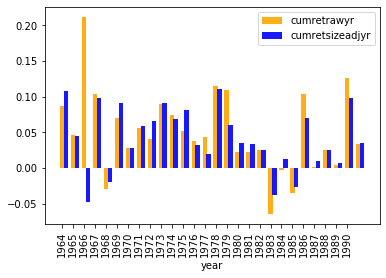

In [105]:
plt.bar(table_result['Year'],table_result['cumretrawyr'],alpha=0.9, width=0.4,color='orange', label='cumretrawyr')
plt.bar(table_result['Year']+0.35,table_result['cumretsizeadjyr'],alpha=0.9, width = 0.4, color='blue', label='cumretsizeadjyr')
plt.xticks(np.arange(table_result['Year'].min(), table_result['Year'].max(), 1))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('year')
plt.show()

In [82]:
table_result['Year'].min()

1964.0